In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark

In [2]:
from pyspark.sql import SQLContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
import utils
%matplotlib inline

In [3]:
from pyspark import SparkContext
sc = SparkContext("local", "My App")
sqlContext = SQLContext(sc)
df = sqlContext.read.load('minute_weather.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

In [4]:
df.count()

1587257

In [33]:
#Reduce to 1/10 of the data
filteredDF = df.filter((df.rowID % 10) == 0)
filteredDF.count()

158726

In [34]:
filteredDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,158726,793625.0,458203.9375103623,0,1587250
hpwren_timestamp,158726,None,None,2011-09-10 00:00:49,2014-09-10 23:53:29
air_pressure,158726,916.830161410269,3.0517165528304218,905.0,929.5
air_temp,158726,61.8515891536367,11.83356921064173,31.64,99.5
avg_wind_direction,158680,162.15610032770354,95.27820101905971,0.0,359.0
avg_wind_speed,158680,2.7752148979077846,2.0576239697426213,0.0,31.9
max_wind_direction,158680,163.46214393748426,92.45213853838614,0.0,359.0
max_wind_speed,158680,3.400557726241582,2.4188016208098935,0.1,36.0
min_wind_direction,158680,166.77401688933702,97.44110914784639,0.0,359.0


In [35]:
filteredDF.filter(filteredDF.rain_accumulation == 0.0).count() 

157812

In [36]:
filteredDF.filter(filteredDF.rain_duration == 0.0).count() 

157237

In [37]:
#Remove unnecessary rows
workingDF = filteredDF.drop('rain_accumulation').drop('rain_duration').drop('hpwren_timestamp')

In [38]:
before = workingDF.count()
#Drop NA rows
workingDF = workingDF.na.drop()
after = workingDF.count()
before - after

46

In [39]:
workingDF.stat.corr('min_wind_speed', "avg_wind_speed")

0.9708621148272656

In [11]:
workingDF.columns

['rowID',
 'air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'relative_humidity']

In [15]:
featuresUsed = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(workingDF)

In [16]:
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [17]:
scaledData = scaledData.select("features", "rowID") #This is how you select columns from spark dataframe
#Use smaller subset for fast result
elbowset = scaledData.filter((scaledData.rowID % 3) == 0).select("features")
#persist to keep it in-memory or cache for fast calculation
elbowset.persist()

DataFrame[features: vector]

In [18]:
clusters = range(2,31) #Creating number of cluster ranges to find the optimum number 'K' using elbow method
wsseList = utils.elbow(elbowset, clusters)

Training for cluster size 2 
......................WSSE = 114993.73508526216 
Training for cluster size 3 
......................WSSE = 102466.31220353257 
Training for cluster size 4 
......................WSSE = 95151.50105820014 
Training for cluster size 5 
......................WSSE = 92076.32347113916 
Training for cluster size 6 
......................WSSE = 84759.76929146728 
Training for cluster size 7 
......................WSSE = 82689.08581108255 
Training for cluster size 8 
......................WSSE = 78897.42030240592 
Training for cluster size 9 
......................WSSE = 76048.71871742973 
Training for cluster size 10 
......................WSSE = 74359.22850986672 
Training for cluster size 11 
......................WSSE = 71334.69986795336 
Training for cluster size 12 
......................WSSE = 70102.20833343921 
Training for cluster size 13 
......................WSSE = 68751.17112036466 
Training for cluster size 14 
......................WSSE = 67481.78146

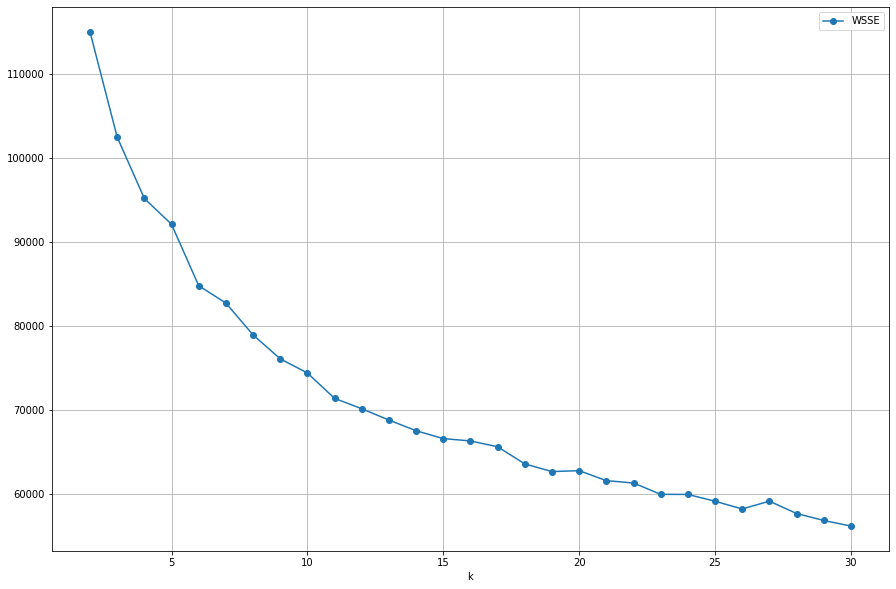

In [19]:
utils.elbow_plot(wsseList, clusters)

In [20]:
#Use the entire data for final k-means K=12
scaledDataFeat = scaledData.select("features")
scaledDataFeat.persist()

DataFrame[features: vector]

In [29]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)

In [30]:
centers = model.clusterCenters()
centers

[array([-0.46275902,  0.13705919, -1.19109171, -0.56095363, -1.07526981,
        -0.59388878,  0.18571712]),
 array([ 1.18647942, -0.15661363,  0.53301293, -0.43122074,  0.7245592 ,
        -0.42870335, -0.82149866]),
 array([-0.85627428, -0.19279467,  0.45159927,  1.66184825,  0.53298874,
         1.59133763,  0.2519497 ]),
 array([ 0.03879798,  0.93429474,  1.46303033, -0.63509154,  1.72383546,
        -0.58650772, -0.75784945]),
 array([-0.14835527, -0.05238526,  0.23376632, -0.5601662 ,  0.41893044,
        -0.56335558,  0.46444291]),
 array([ 1.21783541, -0.34226894, -1.16467275,  2.66565641, -1.06684548,
         2.79551   , -1.16645685]),
 array([-0.47906596, -1.16587281,  1.2886289 , -0.51662206,  1.57542445,
        -0.43925317,  1.10955779]),
 array([-0.1069673 ,  0.79229534,  0.43108141,  0.62173682,  0.54350774,
         0.57019255, -0.2247149 ]),
 array([ 0.22186825,  1.04019298,  0.25958429, -0.67899215,  0.45672797,
        -0.68314058, -0.71675707]),
 array([ 1.28705338

In [31]:
P = utils.pd_centers(featuresUsed, centers)

## Dry Days

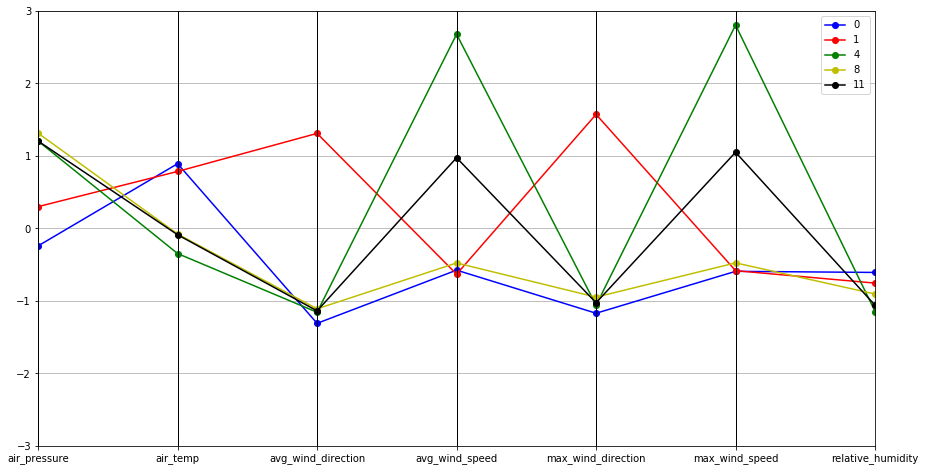

In [24]:
utils.parallel_plot(P[P['relative_humidity'] < -0.5], P)

## Warm Days

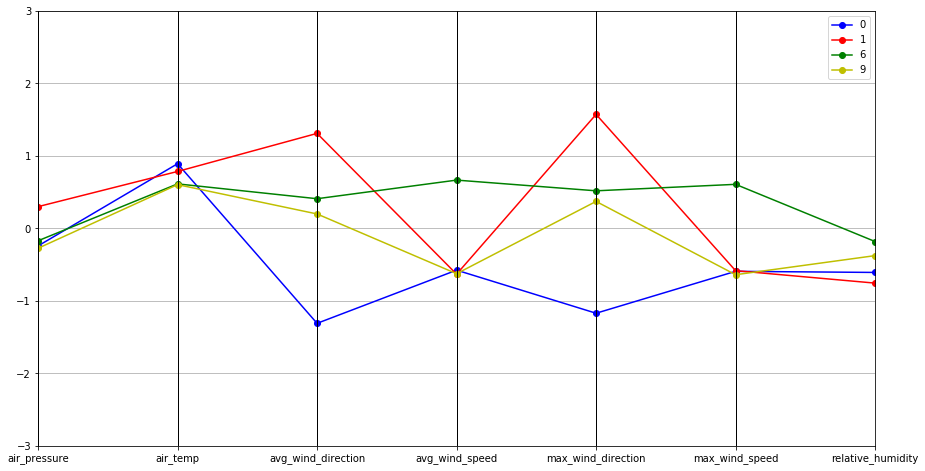

In [26]:
utils.parallel_plot(P[P['air_temp'] > 0.5], P)

## Cool Days

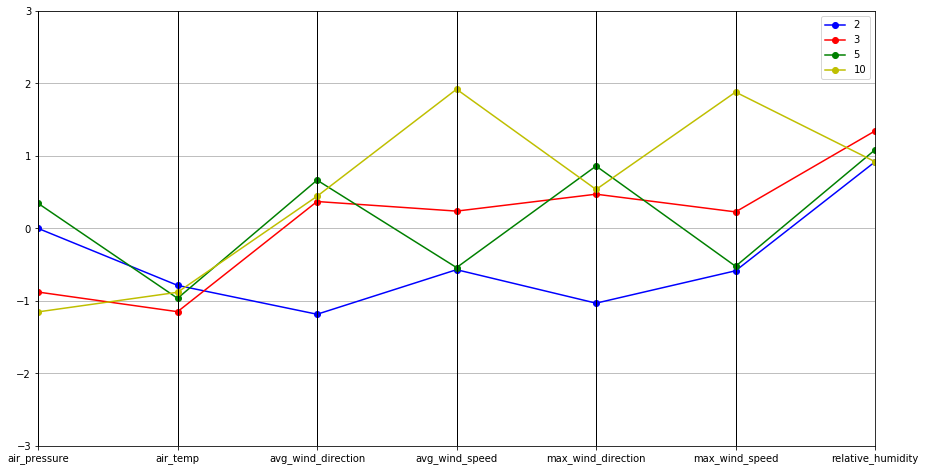

In [27]:
utils.parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)], P)

## Other Days

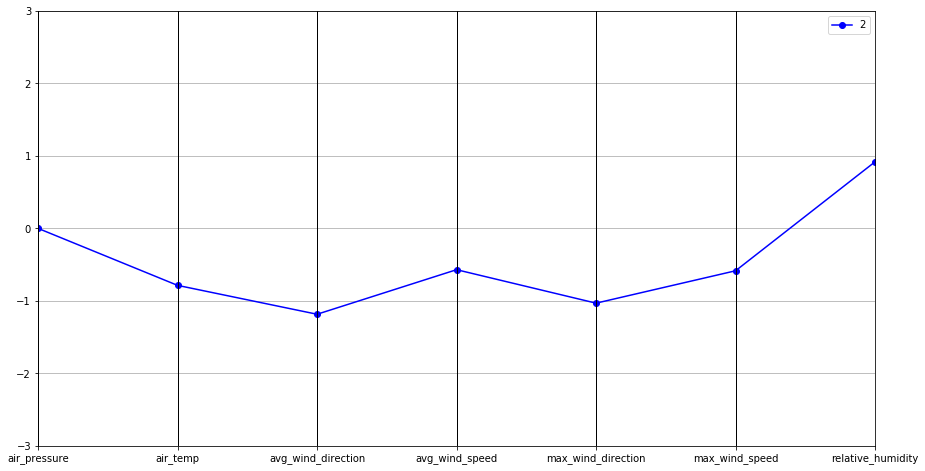

In [28]:
utils.parallel_plot(P.iloc[[2]], P)

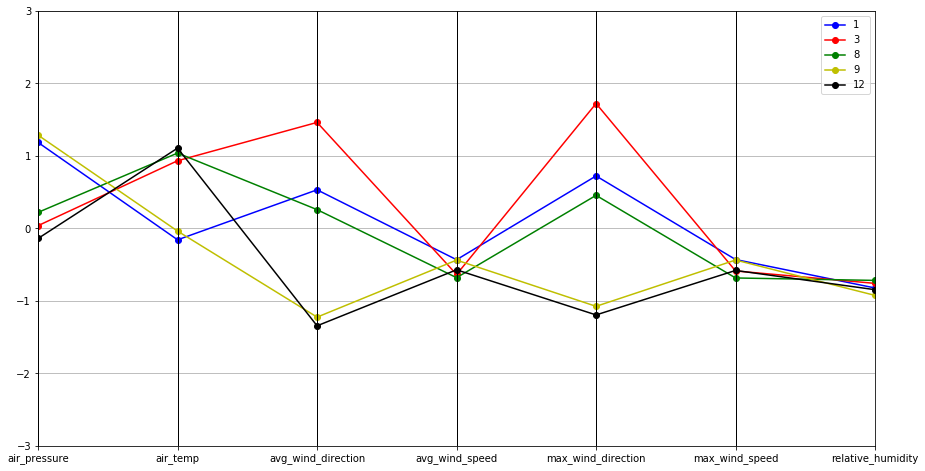

In [32]:
utils.parallel_plot(P[(P['relative_humidity'] < -0.5) & (P['max_wind_speed'] < 0.5)], P)